In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.color import label2rgb
from skimage.morphology import skeletonize
import math

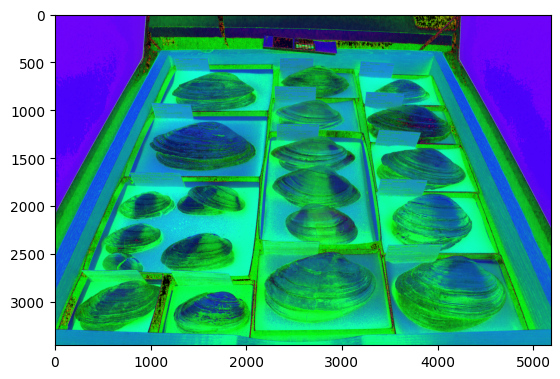

In [37]:
img = cv2.imread("20230728_01F.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
final_mask = np.zeros_like(img)
plt.imshow(img)

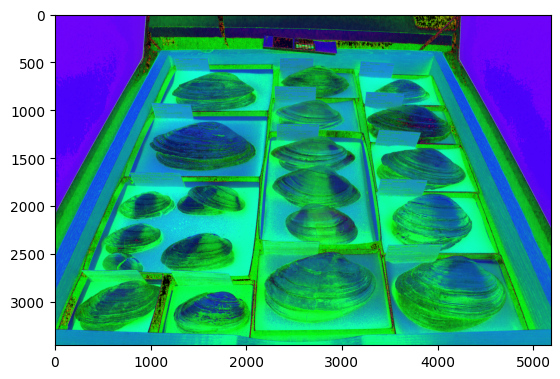

In [38]:
# img = cv2.bilateralFilter(img, 15, 100, 100)
# img = cv2.GaussianBlur(img,(5,5),0)
plt.imshow(img)

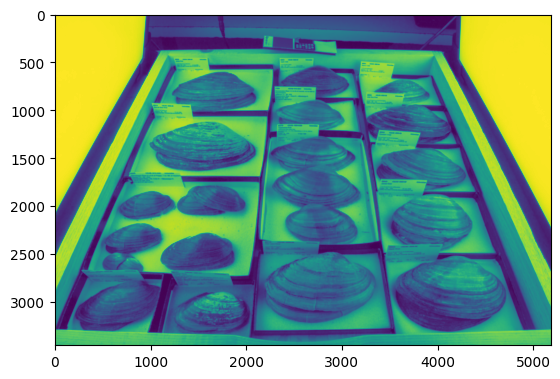

In [56]:
gray = img[:,:,2]
gray = cv2.bilateralFilter(gray,15, 100, 100)
# plt.imshow(gray)
# mask = np.zeros((gray.shape),np.uint8)
# kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(100,50))

# close = cv2.morphologyEx(gray,cv2.MORPH_CLOSE,kernel1)
# div = np.float32(gray)/(close)
# res = np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX))
# res2 = cv2.cvtColor(res,cv2.COLOR_GRAY2BGR)
plt.imshow(gray)

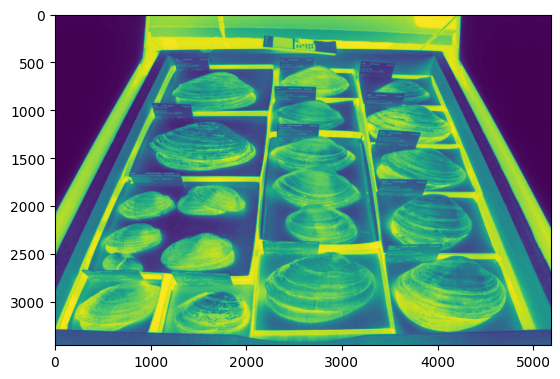

In [58]:
plt.imshow((255-gray))

In [59]:
ddepth = cv2.CV_16S
kernel_size = 3
scale = 1
delta = 0

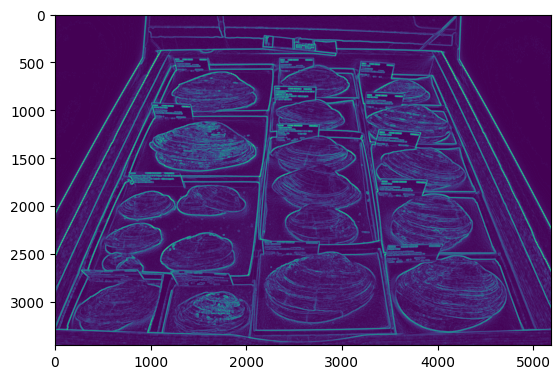

In [60]:
grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=-1, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
# Gradient-Y
# grad_y = cv.Scharr(gray,ddepth,0,1)
grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=-1, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)


abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)


grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

plt.imshow(cv2.normalize(grad,grad,0,255,cv2.NORM_MINMAX))

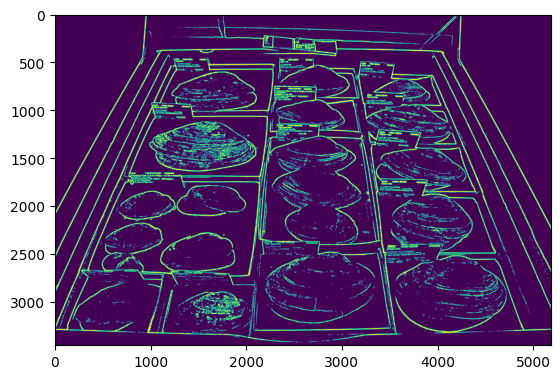

In [62]:
_, tmp_mask = cv2.threshold(grad,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(tmp_mask)

In [44]:
contours, hierarchy = cv2.findContours(tmp_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

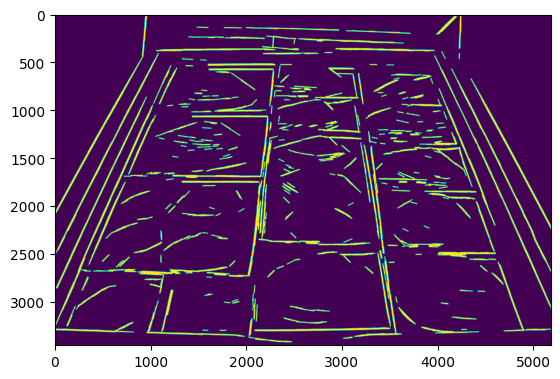

In [51]:
lines = np.squeeze(cv2.HoughLinesP(tmp_mask, 1, np.pi/180, 360, None, 50, 1))
im = np.zeros_like(tmp_mask)
for line in lines:
    cv2.line(im, (line[0], line[1]), (line[2], line[3]), 255, 10)
plt.imshow(im)

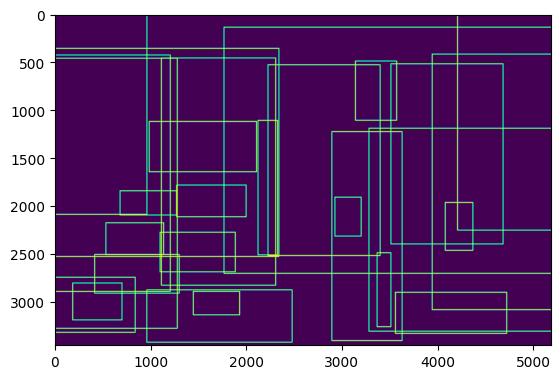

In [45]:
contours, hierarchy = cv2.findContours(tmp_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
im = np.zeros_like(tmp_mask)
for cnt in contours:
    rect = cv2.boundingRect(cnt)
    x, y, w, h = rect
    if w*h > 100000:
#         contours = [i for i in contours if cv2.contourArea(i)>100]
#         cv2.drawContours(im, contours, -1, 255, 3)
        cv2.rectangle(im, (x, y), (x+w, y+h), 255, 10)
plt.imshow(im)

In [46]:
# test_im = 255-cv2.medianBlur(res, 3)
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (tmp_mask.shape[0]//100, 3))
# Apply morphology operations
horizontal = cv2.erode(tmp_mask, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)
_, horizontal = cv2.threshold(horizontal,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
horizontal = cv2.erode(horizontal, None, iterations=1)

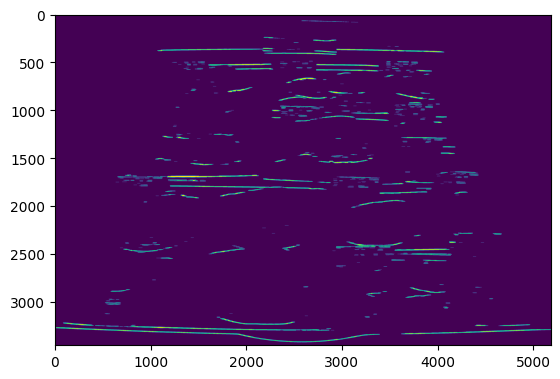

In [17]:
plt.imshow(horizontal)

In [18]:
# test_im = 255-cv2.medianBlur(res, 3)
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1,tmp_mask.shape[1]//100))
# Apply morphology operations
vertical = cv2.erode(tmp_mask, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)
_, vertical = cv2.threshold(vertical,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
vertical = cv2.erode(vertical, None, iterations=1)

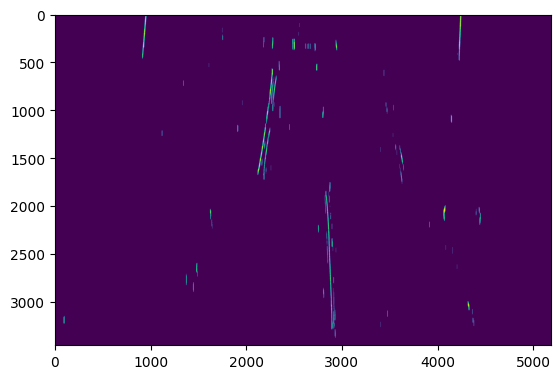

In [19]:
plt.imshow(vertical)

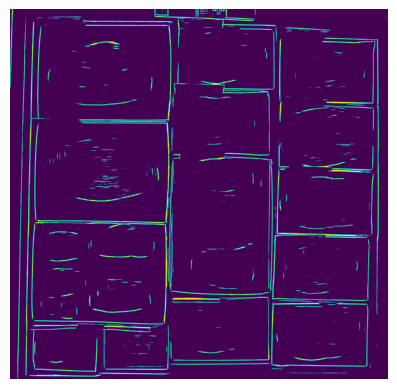

In [16]:
final = vertical+horizontal
plt.axis('off')
plt.imshow(final)

In [296]:
vert_lines = np.squeeze(cv2.HoughLinesP(vertical, 1, np.pi/2, 1, None, 50, 1))
vert_bounds = np.vstack(np.split(vert_lines, 2, axis=1))[:, 0]
vert_points = np.vstack(np.split(vert_lines, 2, axis=1))
hor_lines = np.squeeze(cv2.HoughLinesP(horizontal, 1, np.pi/2, 1, None, 50, 1))
hor_bounds = np.vstack(np.split(hor_lines, 2, axis=1))[:, 1]
hor_points = np.vstack(np.split(hor_lines, 2, axis=1))

In [297]:
hor_fixed_lines = []
for line in np.stack(np.split(hor_lines, 2, axis=1), axis=1):
    p1, p2 = sorted(line, key=lambda x: x[0])
#     print(vert_bounds[vert_bounds<ymin_curr])
    if vert_bounds[vert_bounds<p1[0]].size>0:
        ymin_fixed = np.max(vert_bounds[vert_bounds<p1[0]])
    else:
        ymin_fixed = p1[0]
    if vert_bounds[vert_bounds>p2[0]].size>0:
        ymax_fixed = np.min(vert_bounds[vert_bounds>p2[0]])
    else:
        ymax_fixed = p2[0]
    hor_fixed_lines.append([ymin_fixed, p1[1], ymax_fixed,  p2[1]])

In [298]:
vert_fixed_lines = []
for line in np.stack(np.split(vert_lines, 2, axis=1), axis=1):
    p1, p2 = sorted(line, key=lambda x: x[1])
#     print(vert_bounds[vert_bounds<ymin_curr])
    if hor_bounds[hor_bounds<p1[1]].size>0:
        xmin_fixed = np.max(hor_bounds[hor_bounds<p1[1]])
    else:
        xmin_fixed = p1[1]
    if hor_bounds[hor_bounds>p2[1]].size>0:
        xmax_fixed = np.min(hor_bounds[hor_bounds>p2[1]])
    else:
        xmax_fixed = p2[1]
    vert_fixed_lines.append([p1[0], xmin_fixed, p2[0], xmax_fixed])

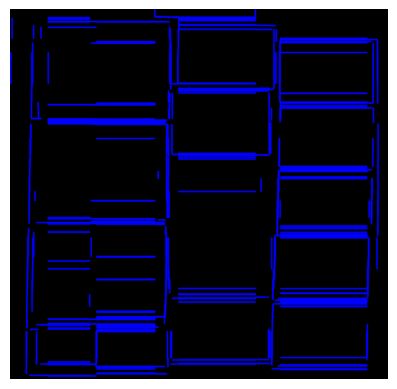

In [299]:
corrected_lines = np.vstack([hor_fixed_lines, vert_fixed_lines])
im = np.zeros_like(img)
for line in corrected_lines:
    x,y,w,h = line
    cv2.line(im, (x, y), (w,h), (0,0,255), 15)
#     break
plt.axis('off')
plt.imshow(im)

(-0.5, 4099.5, 4009.5, -0.5)

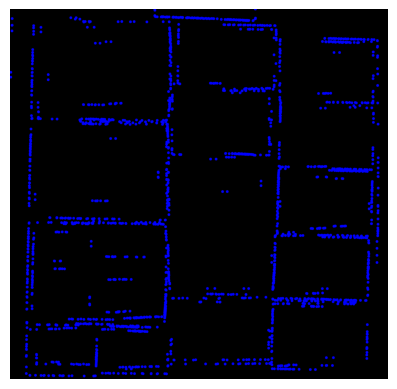

In [300]:
im = np.zeros_like(img)
for line in np.vstack([vert_points,hor_points]):
    x,y = line
    cv2.circle(im, (x, y), 15, (0,0,255), -1)
#     break
plt.imshow(im)
plt.axis('off')


In [208]:
vert_lines[0]

array([3875, 3524, 3875, 3420], dtype=int32)

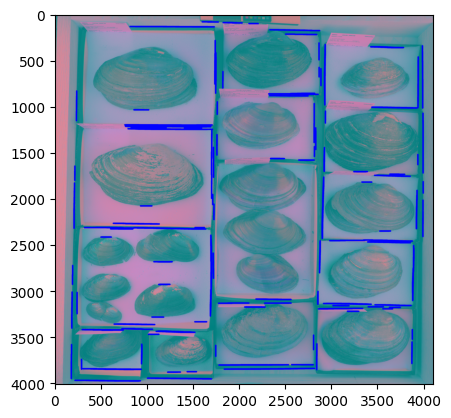

In [126]:
# getting bounds for vertical lines
# edges = cv2.Canny(final, 80, 120)
lines = cv2.HoughLinesP(final, 1, np.pi/2, 1, None, 100, 1)
im = img.copy()
for line in lines:
    x,y,w,h = line[0]
    cv2.line(im, (x, y), (w,h), (0,0,255), 15)
#     break
plt.imshow(im)

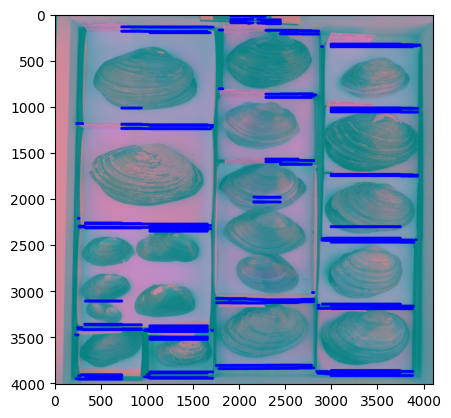

In [23]:
im = img.copy()
for line in hor:
    x,y,w,h = line
    cv2.line(im, (x, y), (w,h), (0,0,255), 30)
plt.imshow(im)

In [13]:
edges = cv2.Canny(final, 80, 120)
lines = cv2.HoughLinesP(edges, 1, np.pi/2, 1, None, 10, 1);
hor = np.array([i[0] for i in lines if i[0][1]==i[0][3]])
hor_b = np.array([i[1] for i in hor])
vert = np.array([i[0] for i in lines if i[0][0]==i[0][2]])
vert_b = np.array([i[0] for i in vert])

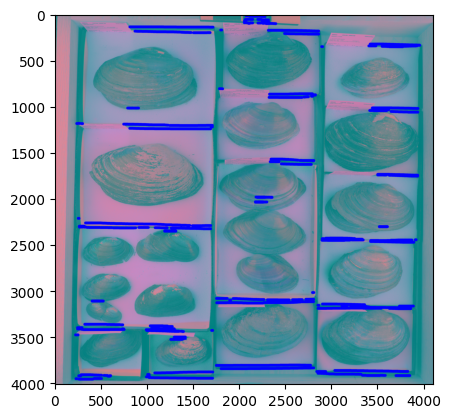

In [14]:
im = img.copy()
for line in hor:
    x,y,w,h = line
    cv2.line(im, (x, y), (w,h), (0,0,255), 30)
plt.imshow(im)

In [15]:
for i in range(hor.shape[0]):
    left_curr = get_left(hor[i])
    right_curr = get_right(hor[i])
    y = hor[i][1]
    try:
        left_best =np.max(vert_b[vert_b<=left_curr])
    except:
        left_best = left_curr
    try:
        right_best = np.min(vert_b[vert_b>=right_curr])
    except:
        right_best = right_curr
    hor[i] = [left_best, y, right_best, y]

In [16]:
for i in range(vert.shape[0]):
    top_curr = get_top(vert[i])
    bottom_curr = get_bottom(vert[i])
    x = vert[i][0]
    try:
        top_curr = np.max(hor_b[hor_b<=top_curr])
    except:
        pass
    try:
        bottom_curr = np.min(hor_b[hor_b>=bottom_curr])
    except:
        pass
    vert[i] = [x, top_curr, x, bottom_curr]

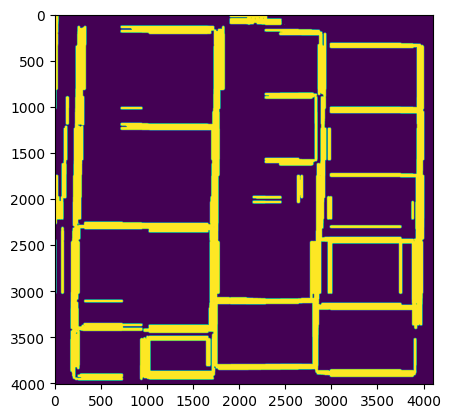

In [17]:
lines = np.vstack([hor, vert])
im = final.copy()
for line in lines:
    x,y,w,h = line
    cv2.line(im, (x, y), (w,h), 255, 30)
plt.imshow(im)

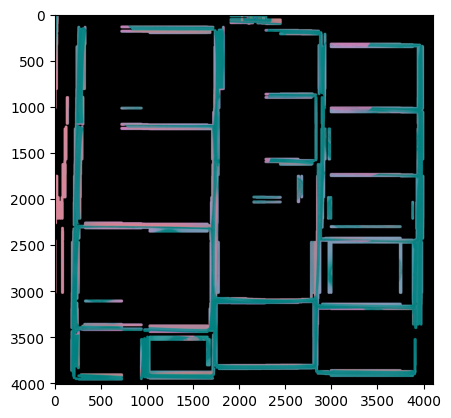

In [25]:
plt.imshow(cv2.bitwise_and(img, img, mask=im))